# Mutual Information for a Gaussian System

In [1]:
import numpy as np
from matplotlib import pyplot
from matplotlib.colors import Normalize
from matplotlib.ticker import PercentFormatter
import scipy
from scipy import stats
from scipy.special import logsumexp
from IPython.display import Markdown
import seaborn as sns
import pandas as pd
import itertools
import functools
import dask.bag as db

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


Make the plot style nice

In [2]:
sns.set_style('whitegrid')
sns.set_context('paper')

Set the path for the results

In [3]:
import pathlib
path = pathlib.Path.home() / 'gaussian_system' / 'plots'
path

PosixPath('/home/ipausers/reinhardt/gaussian_system/plots')

First we define some parameters for our system

In [4]:
lamda = 0.005
kappa = 0.25
rho = 0.01
mu = 0.01
mean_s = kappa / lamda
mean_x = mean_s * rho / mu
tau_s = 1/lamda
tau_x = 1/mu * (1 + rho * mu / (lamda * (lamda + rho + mu)))

The analytical rate is defined by $R(S,X)=\frac{\lambda}{2}\left[\sqrt{1+\rho/\lambda}-1\right]$

In [5]:
analytical_rate = lambda rho, lamda: lamda/2 * (np.sqrt(1 + rho/lamda) - 1)
Markdown("R(S,X) = {}".format(analytical_rate(rho, lamda)))

R(S,X) = 0.001830127018922193

## Correlation functions

Next we define the correlation functions for a very simple birth-death process:

$\sigma_{ss}(t), \sigma_{sx}(t), \sigma_{xs}(t), \sigma_{xx}(t)$

In [6]:
def sigma_ss(rho, mu, lamda, kappa):
    return kappa / lamda

def sigma_xs(rho, mu, lamda, kappa):
    return sigma_ss(rho, mu, lamda, kappa) / (lamda + mu)

def sigma_xx(rho, mu, lamda, kappa):
    return kappa / lamda * rho / mu * (1 + rho / (lamda + mu))

def corr_ss(t, rho, mu, lamda, kappa):
    return kappa / lamda * np.exp(-np.abs(t) * lamda)

def corr_xs_pos(t, rho, mu, lamda, kappa):
    return rho * kappa / lamda / (lamda + mu) * np.exp(-lamda * t)

def corr_sx_pos(t, rho, mu, lamda, kappa):
    a = rho * kappa / lamda / (lamda - mu)
    b1 = (1 + (lamda - mu)/(lamda + mu))*np.exp(-mu * t)
    b2 = - np.exp(-lamda * np.abs(t))
    return a * (b1 + b2)

def corr_xs(t, rho, mu, lamda, kappa):
    return np.where(t >= 0, corr_xs_pos(t, rho, mu, lamda, kappa), corr_sx_pos(-t, rho, mu, lamda, kappa))

def corr_sx(t, rho, mu, lamda, kappa):
    return np.where(t >= 0, corr_sx_pos(t, rho, mu, lamda, kappa), corr_xs_pos(-t, rho, mu, lamda, kappa))

def corr_xx(t, rho, mu, lamda, kappa):
    c1 = np.exp(-mu * np.abs(t)) - np.exp(-lamda * np.abs(t))
    c2 = np.exp(-mu * np.abs(t))
    d1 = rho**2 / (lamda**2 - mu**2) * kappa / lamda
    d2 = (1+rho/(lamda+mu)) * kappa / lamda * rho / mu
    return (d1*c1 + d2*c2)

def corr_z(t, rho, mu, lamda, kappa):
    c_ss = corr_ss(t, rho, mu, lamda, kappa)
    c_sx = corr_sx(t, rho, mu, lamda, kappa)
    c_xs = corr_xs(t, rho, mu, lamda, kappa)
    c_xx = corr_xx(t, rho, mu, lamda, kappa)
    return np.block([[c_ss, c_sx], [c_xs, c_xx]])

def time_matrix(N, delta_t):
    time_stamps = np.expand_dims(np.linspace(0, (N-1)*delta_t, N), 0)
    return time_stamps - time_stamps.T

In [7]:
def gen_corr_matrices(n_dim, dt):
    data = []
    for n_dim, dt in itertools.product(np.array(n_dim), np.array(dt)):
        t = time_matrix(n_dim, dt)
        c_z = corr_z(t, rho, mu, lamda, kappa)
        data.append({'n_dim': n_dim, 'dt': dt, 'correlation': c_z})
    return pd.DataFrame(data)

def save_corr_matrices():
    data = gen_corr_matrices([10, 80, 640], [1, 8, 64])
    data.to_json(path / 'corr_matrices/data.json')

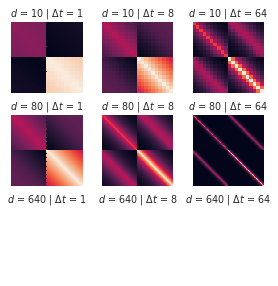

In [13]:
data = pd.read_json(path / 'corr_matrices/data.json')

def draw_heatmap(*args, **kw_args):
    return sns.heatmap(args[0].values[0], **kw_args)
        
g = sns.FacetGrid(data, col='dt', row='n_dim', sharex=False, sharey=False, aspect=1, height=4/2.54, gridspec_kws={"wspace": 0.1, "hspace": 0.3})
g = g.map(draw_heatmap, 'correlation', cbar=False, xticklabels=False, yticklabels=False, square=True)\
    .set_titles("$d$ = {row_name} | $\Delta t$ = {col_name}")\
    .set(xlabel=None)
g.savefig(path / 'corr_matrices/matrix_plots.png', dpi=300)

# Estimates

## Analytic Expressions

In the following we implement the analytic expressions for the mutual information and the conditional entropy.

In [333]:
# from https://blogs.sas.com/content/iml/2012/10/31/compute-the-log-determinant-of-a-matrix.html
def logdet_symmetric(matrix):
    lower_triangular = np.linalg.cholesky(matrix)
    return 2 * np.sum(np.log(np.diag(lower_triangular)))

In [9]:
def mutual_information_from_matrix(t, rho, mu, lamda, kappa):
    c_ss = np.atleast_2d(corr_ss(t, rho, mu, lamda, kappa))
    c_xx = np.atleast_2d(corr_xx(t, rho, mu, lamda, kappa))
    z = np.atleast_2d(corr_z(t, rho, mu,  lamda, kappa))
    
    det_c_ss = logdet_symmetric(c_ss)
    det_c_xx = logdet_symmetric(c_xx)    
    det_z = logdet_symmetric(z)
    
    return 0.5 * (det_c_ss + det_c_xx - det_z)

def conditional_entropy_from_matrix(t, rho, mu, lamda, kappa):
    c_ss = corr_ss(t, rho, mu, lamda, kappa)
    z = corr_z(t, rho, mu,  lamda, kappa)
    
    det_c_ss = logdet_symmetric(c_ss)
    n = c_ss.shape[0]
    det_z = logdet_symmetric(z)
        
    return 0.5 * (det_z - det_c_ss + n*np.log(2*np.pi*np.e))

def marginal_entropy_from_matrix(t):
    c_xx = corr_xx(t, rho, mu, lamda, kappa)
    return stats.multivariate_normal(cov=c_xx).entropy()

## Monte Carlo Estimates

In [10]:
def estimate_p_x(num_x, num_s, t, renew=True):
    joint = stats.multivariate_normal(cov=corr_z(t, rho, mu, lamda, kappa))
    marg_x = stats.multivariate_normal(cov=corr_xx(t, rho, mu, lamda, kappa))
    marg_s = stats.multivariate_normal(cov=corr_ss(t, rho, mu, lamda, kappa))
    
    num_s_components = marg_s.cov.shape[0]
    
    x = marg_x.rvs(num_x).reshape((num_x, -1))
    s_shape = x.shape[:-1] + (num_s, num_s_components)
    if renew:
        s_samples = marg_s.rvs(x.shape[:-1] + (num_s,)).reshape(s_shape)
    else:
        s_samples = marg_s.rvs((num_s,)).reshape((num_s, num_s_components))
        s_samples = np.broadcast_to(s_samples, s_shape)
    x_grid = np.broadcast_to(np.expand_dims(x, -2), x.shape[:-1] + (num_s, x.shape[-1]))
    
    points = np.concatenate((s_samples, x_grid), axis=-1)
    likelihood =  -marg_s.logpdf(s_samples) + joint.logpdf(points)
    return x, -(logsumexp(likelihood, axis=-1) - np.log(num_s))

def estimate_p_x_weighted(num_x, num_s, t):
    joint = stats.multivariate_normal(cov=corr_z(t, rho, mu, lamda, kappa))
    marg_s = stats.multivariate_normal(cov=corr_ss(t, rho, mu, lamda, kappa))
    
    num_s_components = marg_s.cov.shape[0]
    
    c_ss = np.atleast_2d(corr_ss(t, rho, mu, lamda, kappa))
    c_sx = np.atleast_2d(corr_sx(t, rho, mu, lamda, kappa))
    c_xs = np.atleast_2d(corr_xs(t, rho, mu, lamda, kappa))
    c_xx = np.atleast_2d(corr_xx(t, rho, mu, lamda, kappa))
    
    marg_x = stats.multivariate_normal(cov=c_xx)
    
    regression_coef = c_sx @ np.linalg.inv(c_xx)
    p_s_given_x_cov = c_ss - regression_coef @ c_xs
    
    likelihoods = []
    xs=[]
    for s_x in joint.rvs(num_x).reshape((num_x, -1)):
        s = s_x[:num_s_components]
        x = s_x[num_s_components:]
        posterior = stats.multivariate_normal(mean=np.dot(regression_coef, x), cov=p_s_given_x_cov)
        posterior_draws = posterior.rvs(num_s_components*16).reshape((num_s_components*16, -1))
        ml_cov = np.atleast_2d(np.cov(posterior_draws, rowvar=False, ddof=0))
        weight = stats.multivariate_normal(mean=posterior_draws.mean(axis=0), cov=ml_cov)
    
        mc_samples = weight.rvs(num_s).reshape((num_s, -1))
        
        conc_samples = np.concatenate((mc_samples, np.vstack((x,) * num_s)), axis=-1)
        xs.append(x)
        likelihoods.append(-weight.logpdf(mc_samples) + joint.logpdf(conc_samples))
    return np.array(xs), -(logsumexp(likelihoods, axis=-1) - np.log(num_s))
        

def conditional_covariance(t):
    c_ss = corr_ss(t, rho, mu, lamda, kappa)
    c_sx = corr_sx(t, rho, mu, lamda, kappa)
    c_xs = corr_xs(t, rho, mu, lamda, kappa)
    c_xx = corr_xx(t, rho, mu, lamda, kappa)
        
    regression_coef = c_xs @ np.linalg.inv(c_ss)
    return regression_coef, c_xx - regression_coef @ c_sx

def estimate_marginal_entropy(num_x, num_s, t, renew=True, importance=False):
    if importance:
        _, estimated_p_x = estimate_p_x_weighted(num_x, num_s, t)
    else:
        _, estimated_p_x = estimate_p_x(num_x, num_s, t, renew)
        
    return estimated_p_x.mean(axis=-1)

def estimate_conditional_entropy(num_x, num_s, t):
    c_ss = corr_ss(t, rho, mu, lamda, kappa)
    marg_s = stats.multivariate_normal(cov=c_ss)
    
    regression_coef, conditional_cov = conditional_covariance(t)
    
    signals = marg_s.rvs(num_s).reshape((num_s, -1))
    
    signal_averages = []
    for s in signals:
        x_given_s = stats.multivariate_normal(mean=np.dot(regression_coef, s), cov=conditional_cov)
        signal_averages.append(x_given_s.logpdf(x_given_s.rvs(num_x).reshape((num_x, -1))).mean(axis=0))
        
    return -np.mean(signal_averages)

## MCMC Marginal Density Estimate

1.0009720401425062

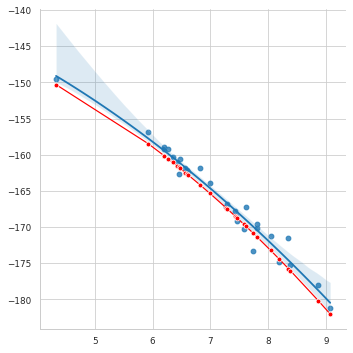

In [174]:
t = time_matrix(50, 64)
c_ss = corr_ss(t, rho, mu, lamda, kappa)
c_sx = corr_sx(t, rho, mu, lamda, kappa)
c_xs = corr_xs(t, rho, mu, lamda, kappa)
c_xx = corr_xx(t, rho, mu, lamda, kappa)

# log likelihood (evaluation of the log density of a conditional Gaussian distribution)
# evaluates P(x|s)
def log_likelihood(x, s, t=t):
    c_ss = corr_ss(t, rho, mu, lamda, kappa)
    c_sx = corr_sx(t, rho, mu, lamda, kappa)
    c_xs = corr_xs(t, rho, mu, lamda, kappa)
    c_xx = corr_xx(t, rho, mu, lamda, kappa)
    regression_coef = c_xs @ np.linalg.inv(c_ss)
    mean = np.inner(s, regression_coef)
    
    # generate the covariance matrix and compute the square root of its inverse
    p_x_given_s_cov = c_xx - regression_coef @ c_sx
    e_val, e_vec = np.linalg.eigh(p_x_given_s_cov)
    prec_U = np.sqrt(np.reciprocal(e_val)) * e_vec
    
    maha = np.sum(np.square(np.inner(x - mean, prec_U.T)), axis=-1)
    return - 0.5 * (np.log(2*np.pi) * len(e_val) + np.sum(np.log(e_val)) + maha)

def mcmc_marginal_entropy(num_x, num_s, t):
    marg_x = stats.multivariate_normal(cov=c_xx)
    x = marg_x.rvs(num_x).reshape((num_x, -1))
    
    # setup posterior distribution
    regression_coef = c_sx @ np.linalg.inv(c_xx)
    p_s_given_x_cov = c_ss - regression_coef @ c_xs
    
    # generate posterior samples
    s = np.zeros((num_x, num_s, c_ss.shape[0]))
    for i, x_sample in enumerate(x):
        posterior = stats.multivariate_normal(mean=np.dot(regression_coef, x_sample), cov=p_s_given_x_cov)
        s[i] = posterior.rvs(num_s).reshape((num_s, -1))
        
    ll = np.swapaxes(log_likelihood(x, np.swapaxes(s, 0, 1)), 0, 1)
        
    return x, np.log(num_s) - logsumexp(-ll, axis=-1)

c_xx = corr_xx(t, rho, mu, lamda, kappa)
marg_x = stats.multivariate_normal(cov=c_xx)
x, me = mcmc_marginal_entropy(30, 1000, t)
df = pd.DataFrame({'distance': np.sqrt(np.einsum('...i,ij,...j', x, np.linalg.inv(c_xx), x)), 'estimate': me, 'analytical': marg_x.logpdf(x)})

grid = sns.lmplot(x='distance', y='estimate', order=2, data=df)
grid.data = df # needed because of a bug in seaborn
grid.map_dataframe(sns.lineplot, x='distance', y='analytical', color='red')
-me.mean() / marg_x.entropy()

## Replica Trick

In [203]:
def replica_estimate(dim: int, delta_t: float, num_x: int, num_s: int, n: int):
    t = time_matrix(dim, delta_t)
    c_ss = corr_ss(t, rho, mu, lamda, kappa)
    c_sx = corr_sx(t, rho, mu, lamda, kappa)
    c_xs = corr_xs(t, rho, mu, lamda, kappa)
    c_xx = corr_xx(t, rho, mu, lamda, kappa)

    @np.vectorize
    def replica_marginal_entropy(num_x: int, num_s: int, power: int):
        marg_x = stats.multivariate_normal(cov=c_xx)
        marg_s = stats.multivariate_normal(cov=c_ss)

        x_samples = marg_x.rvs(num_x).reshape((num_x, 1, 1, -1))

        s_shape = (num_x, num_s, power)
        s_samples = marg_s.rvs(s_shape).reshape(s_shape + (-1,))

        log_l = log_likelihood(x_samples, s_samples, t)
        return logsumexp(np.sum(log_l, axis=-1), axis=(0,1)) - np.log(np.double(num_x * num_s))

    z_n = replica_marginal_entropy(num_x, num_s, n)
    return {"n": n, "logZ^n": z_n, "estimate": "replica", "num responses": num_x, "num signals": num_s, "dim": dim, "delta_t": delta_t}

In [180]:
dicts = []
for n, dim, _ in itertools.product(np.arange(1,15), [5, 50, 200], range(200)):
    dicts.append(replica_estimate(dim, 64, 1, 200, n))
df = pd.DataFrame(dicts)

In [56]:
df = pd.read_json(path / "replica" / "data.json")
df["-logZ^n/n"] = -df["logZ^n"] / df["n"]
df = df.append([{
    "n": n,
    "estimate": "analytical",
    "dim": dim,
    "logZ^n": -marginal_entropy_from_matrix(time_matrix(dim, 64)) * n,
    "-logZ^n/n": marginal_entropy_from_matrix(time_matrix(dim, 64)),
    "delta_t": 64,
} for n, dim in itertools.product([1, 14], [5, 50, 200])])
df[df["estimate"] == "analytical"]

,n,estimate,num responses,num signals,dim,delta_t,logZ^n,-logZ^n/n
0,1,analytical,NaN,NaN,5,64,-16.877578,16.877578
1,1,analytical,NaN,NaN,50,64,-165.906976,165.906976
2,1,analytical,NaN,NaN,200,64,-662.671627,662.671627
3,14,analytical,NaN,NaN,5,64,-236.286095,16.877578
4,14,analytical,NaN,NaN,50,64,-2322.697657,165.906976
5,14,analytical,NaN,NaN,200,64,-9277.402776,662.671627


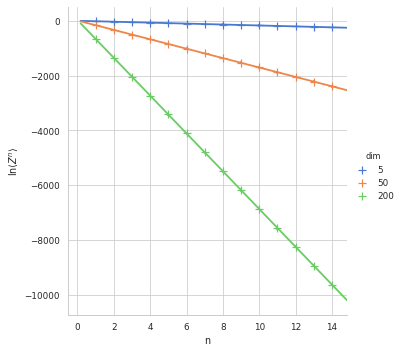

In [53]:
palette = sns.color_palette("muted", 3)
grid = sns.lmplot(x="n", y="logZ^n", hue="dim", truncate=False, x_estimator=np.mean, markers="+", x_ci=99, palette=palette, data=df[df["estimate"] == "replica"])
grid.set(ylabel="$\\ln \\langle Z^n \\rangle$", xlim=(-0.5, None))
grid.savefig(path / "replica" / "ln_z_regression.pdf")

Inspect the linear regression parameters

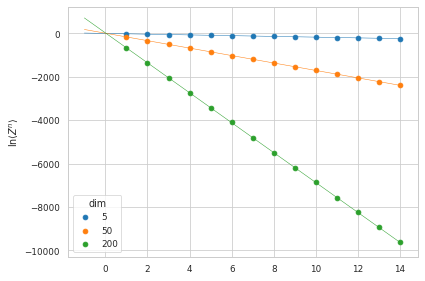

In [196]:
def linear_regression(data, ax=None, **kw_args):
    import statsmodels.api as sm
    import statsmodels.formula.api as smf
    from patsy import dmatrices
    
    if ax is None:
        ax = pyplot.gca()
    xmin, xmax = data.n.min(), data.n.max()
    n = np.linspace(-1, xmax, 100)
    for _, group in data.groupby('dim'):
        res = smf.ols("Q('logZ^n') ~ n", data=group).fit()
        intercept, slope = res.params
        ax.plot(n, intercept + slope * n, linewidth=0.5)
        
def scatter_plots(data, ax=None):
    if ax is None:
        ax = pyplot.gca()
    data = data.groupby(["n", "dim"], as_index=False).mean()
    for dim, group in data.groupby(['dim']):
        ax.scatter(x=group.n, y=group["logZ^n"], label=dim)
    ax.legend(title='dim')

fig, ax1 = pyplot.subplots(1, 1)
# ax1.set_xlim(-0.2, 3.2)
# ax1.set_ylim(-1500, 100)
ax1.set(ylabel="$\\ln \\langle Z^n \\rangle$")
linear_regression(df_ols, ax=ax1)
scatter_plots(df_ols, ax=ax1)
fig.tight_layout()
fig.savefig(path / "replica" / "ln_z_regression.pdf")

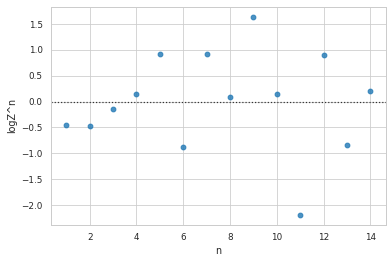

In [202]:
sns.residplot(x="n", y="logZ^n", data=df_ols[df_ols["dim"] == 5].groupby("n", as_index=False).mean())

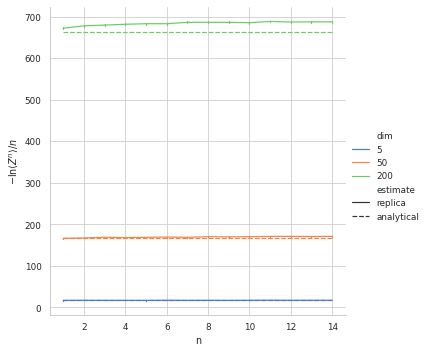

In [255]:
palette = sns.color_palette("muted", 3)
grid = sns.relplot(x="n", y="-logZ^n/n", hue="dim", kind="line", style="estimate", ci=99, err_style="bars", palette=palette, data=df)
grid.set(ylabel="$-\\ln \\langle Z^n \\rangle/n$")
grid.savefig(path / "replica" / "ln_z_over_n.pdf")

In [106]:
stats.multivariate_normal(cov=c_xx).entropy()

165.90697552457215

## $\mathrm P(\mathbf x)$ with and without optimized sampling

In [17]:
def gen_px_samples(num_s, dim, dt):
    scatter_data = []
    for num_s, dim, weighted in itertools.product(num_s, dim, [True, False]):
        t = time_matrix(dim, dt)
        if weighted:
            x, y = estimate_p_x_weighted(100, num_s, t)
        else:
            x, y = estimate_p_x(100, num_s, t)
        y = -y
        c_xx = corr_xx(t, rho, mu, lamda, kappa)
        analytical = stats.multivariate_normal.logpdf(x, cov=c_xx)
        scatter_data.append(pd.DataFrame(data={
            'distance': np.sqrt(np.einsum('...i,ij,...j', x, np.linalg.inv(c_xx), x)), 
            'y': y, 
            'error': (y - analytical), 
            'analytical': analytical, 
            'num_s': num_s, 
            'dimensions': dim, 
            'weighted': weighted, 
            'dt': dt}))
    return pd.concat(scatter_data)
    
def save_px_samples():
    data = gen_px_samples(num_s=[10, 100, 1000], dim=[1, 100, 500], dt=64)
    data.to_json(path / 'px_scatter/data.json', orient='records')

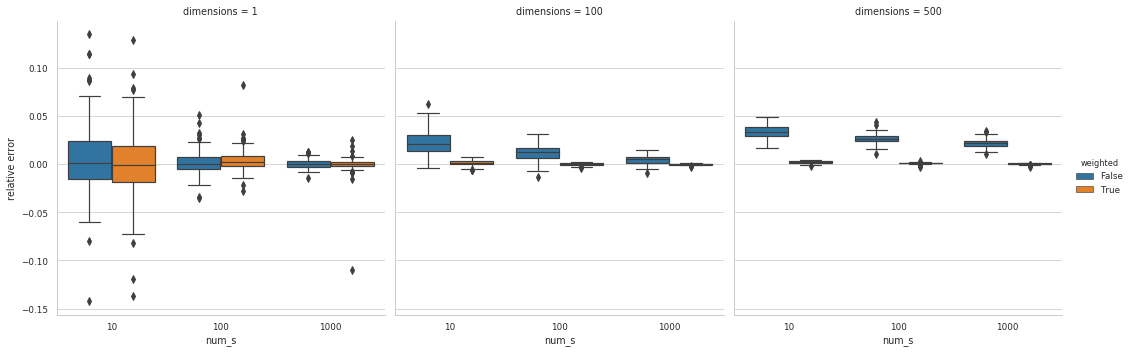

In [18]:
scatter_data = pd.read_json(path / 'px_scatter/data.json')
scatter_data['relative error'] = scatter_data['error'] / scatter_data['analytical']
g = sns.catplot(col='dimensions', y='relative error', x='num_s', kind='box', hue='weighted', data=scatter_data)
g.savefig(path / 'px_scatter/boxplot.pdf')

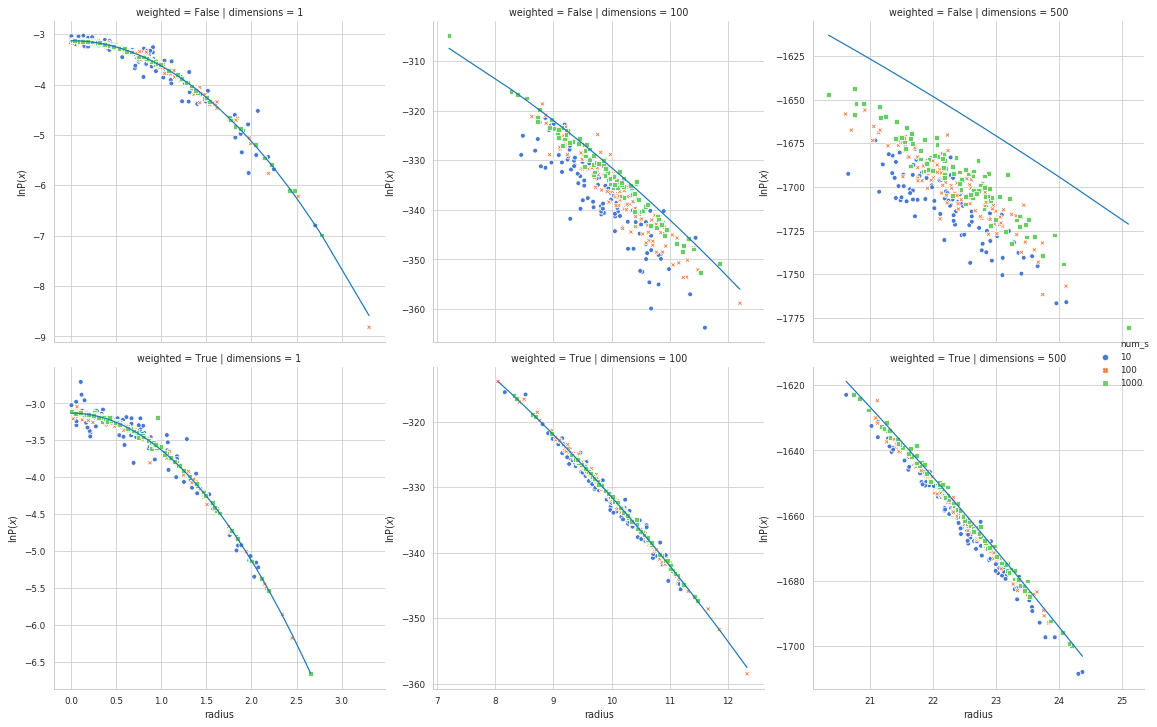

In [19]:
palette = sns.color_palette('muted', 3)
grid = sns.relplot(x='distance', col='dimensions', row='weighted', hue='num_s', y='y', style='num_s', facet_kws={'sharex': 'col', 'sharey': False}, palette=palette, data=scatter_data)
grid.data = scatter_data
grid.map_dataframe(sns.lineplot, x='distance', y='analytical', markers=False)
grid.set(xlabel='radius', ylabel="$\\ln \\mathrm{P}(x)$")
grid.savefig(path / 'px_scatter/scatterplot.pdf')

In [36]:
def generate_sample(dim, num_r, num_s, dt, umbrella, *args):
    t = time_matrix(dim, dt)
    marg_x = stats.multivariate_normal(cov=corr_xx(t, rho, mu, lamda, kappa))
    marginal = estimate_marginal_entropy(num_r, num_s, t, renew=False, importance=umbrella)
    
    conditional = estimate_conditional_entropy(num_r, num_s, t)
    conditional_analytical = conditional_entropy_from_matrix(t, rho, mu, lamda, kappa)

    return {
        "dimensions": dim,
        "marginal entropy": marginal,
        "theory": marg_x.entropy().item(),
        "num signals": num_s,
        "num responses": num_r,
        "umbrella": umbrella,
        "sparsity": dt * dim,
        "conditional entropy": conditional,
        "conditional entropy error": conditional - conditional_analytical,
        "mutual information": marginal - conditional,
        "dt": dt
    }

def generate_sample_with_sparsity(sparsity, dim, num_r, num_s, umbrella):
    return generate_sample(dim, num_r, num_s, sparsity / dim, umbrella)

# Dask workers

In [38]:
def set_one_threaded():
    import mkl
    mkl.set_num_threads(1)

try:
    client
except NameError:   
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster(threads_per_worker=1, scheduler_port=8786, dashboard_address=":8787")
    client = Client(cluster)
    client.run(set_one_threaded)

client

Client Scheduler: tcp://127.0.0.1:8786 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 36 Cores: 36 Memory: 268.44 GB


# Sparsity

In [39]:
def gen_sparsity_data():
    args = db.from_sequence(list(itertools.product(np.linspace(3000, 10000, 8), np.linspace(20, 300, 8).astype(int), [100], [100], [False])) * 64, npartitions=36*16)
    dicts_sparsity = args.starmap(generate_sample_with_sparsity).compute()
    return pd.DataFrame(dicts_sparsity)

def save_sparsity_data():
    data = gen_sparsity_data()
    data.to_json(path / 'sparsity' / 'data.json', orient='records')

In [40]:
df_sparsity = pd.read_json(path / 'sparsity' / 'data.json')
df_sparsity['error'] = df_sparsity['marginal entropy'] - df_sparsity['theory']
df_sparsity['relative error'] = df_sparsity['error'] / df_sparsity['theory']
df_sparsity['sparsity'] = df_sparsity['sparsity'].astype(int)
df_sparsity

,dimensions,marginal entropy,theory,num signals,num responses,umbrella,sparsity,conditional entropy,mutual information,estimate,dt,error,relative error
0,20,71.329835,70.737653,100,100,False,3000,67.815464,3.514371,Monte Carlo,150.000000,0.592182,0.008372
1,60,194.980502,193.993344,100,100,False,3000,189.427937,5.552565,Monte Carlo,50.000000,0.987159,0.005089
2,100,305.362198,303.413293,100,100,False,3000,298.411666,6.950532,Monte Carlo,30.000000,1.948905,0.006423
3,140,406.797754,404.681490,100,100,False,3000,399.530772,7.266982,Monte Carlo,21.428571,2.116264,0.005229
4,180,502.237559,500.168676,100,100,False,3000,494.650315,7.587245,Monte Carlo,16.666667,2.068883,0.004136
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,140,477.859559,468.863146,100,100,False,10000,454.950407,22.909153,Monte Carlo,71.428571,8.996413,0.019188
4092,180,594.593750,587.861034,100,100,False,10000,573.099708,21.494041,Monte Carlo,55.555556,6.732716,0.011453
4093,220,713.176170,702.575618,100,100,False,10000,686.949303,26.226867,Monte Carlo,45.454545,10.600552,0.015088
4094,260,821.951239,813.740859,100,100,False,10000,797.756395,24.194844,Monte Carlo,38.461538,8.210380,0.010090


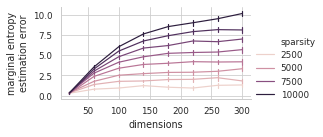

In [41]:
grid = sns.relplot(x='dimensions', y='error', hue='sparsity', kind='line', err_style='bars', aspect=1.8, height=2, data=df_sparsity)
grid.set(ylabel='marginal entropy\nestimation error')
grid.savefig(path / 'sparsity' / 'sparsity.svg')

# Marginal Entropy

In [45]:
# Generating this data takes about 3-5 hours
def save_marginal_entropy_data():
    args = db.from_sequence(list(itertools.product(np.linspace(500, 20000, 8), [200], [100], (1/np.linspace(1/500, 1/1000, 8)).astype(int), [False, True])) * 256, npartitions=36*32)
    dicts = args.starmap(generate_sample_with_sparsity).compute()
    df = pd.DataFrame(dicts)
    df.to_json(path / 'marginal_entropy' / 'data.json', orient='records')

In [302]:
df = pd.read_json(path / 'marginal_entropy' / 'data.json')
df = df[df['umbrella'] == False]
df['error'] = df['marginal entropy'] - df['theory']
df['relative error'] = df['error'] / df['theory']
df['absolute error'] = df['error'].abs()
df['inverse responses'] = 1/df['num responses']
df['inverse signals'] = 1/df['num signals']
df

,dimensions,marginal entropy,theory,num signals,num responses,umbrella,sparsity,conditional entropy,conditional entropy error,mutual information,dt,error,relative error,absolute error,inverse responses,inverse signals
0,200,374.988675,375.598405,500,100,False,500.0,374.519047,-0.021389,0.469628,2.5,-0.609729,-0.001623,0.609729,0.01,0.002000
2,200,374.817616,375.598405,538,100,False,500.0,374.579348,0.038912,0.238267,2.5,-0.780789,-0.002079,0.780789,0.01,0.001859
4,200,374.867770,375.598405,583,100,False,500.0,374.591934,0.051497,0.275836,2.5,-0.730635,-0.001945,0.730635,0.01,0.001715
6,200,373.594370,375.598405,636,100,False,500.0,374.521241,-0.019195,-0.926872,2.5,-2.004035,-0.005336,2.004035,0.01,0.001572
8,200,375.465673,375.598405,700,100,False,500.0,374.523999,-0.016437,0.941674,2.5,-0.132732,-0.000353,0.132732,0.01,0.001429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32758,200,703.188902,688.804454,636,100,False,20000.0,664.215376,-0.018734,38.973526,100.0,14.384448,0.020883,14.384448,0.01,0.001572
32760,200,703.505003,688.804454,700,100,False,20000.0,664.227034,-0.007075,39.277969,100.0,14.700549,0.021342,14.700549,0.01,0.001429
32762,200,700.792884,688.804454,777,100,False,20000.0,664.244636,0.010527,36.548248,100.0,11.988431,0.017405,11.988431,0.01,0.001287
32764,200,701.874807,688.804454,874,100,False,20000.0,664.210253,-0.023857,37.664554,100.0,13.070353,0.018975,13.070353,0.01,0.001144


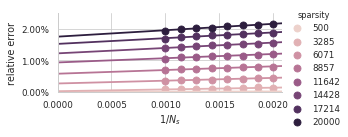

In [305]:
sns.set_context("paper")
palette = sns.cubehelix_palette(8)
df['sparsity'] = df['sparsity'].astype(int)
grid = sns.lmplot(x='inverse signals', y='relative error', aspect=2.3, height=4.6/2.54, hue="sparsity", truncate=False, x_estimator=np.mean, ci=None, palette=palette, data=df)
grid.set(xlim=(0, 1/480), ylim=(-0, 0.025))
grid.set_axis_labels('$1/N_s$', 'relative error')
grid.axes[0, 0].yaxis.set_major_formatter(PercentFormatter(1))
pyplot.savefig(path / 'marginal_entropy' / 'error_grid.svg', dpi=96)

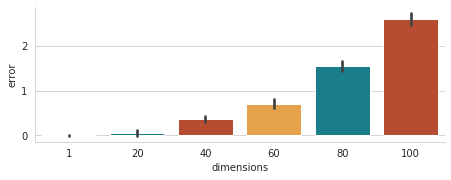

In [167]:
df['sparsity'] = df['dt']
palette = sns.color_palette(['#ffa630', '#068D9D', '#cd401a'])
df['sampling strategy'] = df['umbrella'].map(lambda umb: "optimized" if umb else "naïve")
grid = sns.catplot(x='dimensions', y='error', height=250/96, aspect=2.5, kind='bar', palette=palette, data=df[df['sampling strategy'] == 'naïve'])
grid.savefig("sampling1.svg")

In [ ]:
args = db.from_sequence(list(itertools.product(np.linspace(500, 20000, 10), [200], [200], [10, 80, 320], [False, True])) * 64, npartitions=36*8)
dicts = args.starmap(generate_sample_with_sparsity)
                        
df_sampling = dicts.to_dataframe()
df_sampling['error'] = df_sampling['marginal entropy'] - df_sampling['theory']
df_sampling['relative error'] = df_sampling['error'] / df_sampling['theory']
df_sampling = df_sampling.persist()
df_sampling

In [366]:
df_sampling = df_sampling.compute()

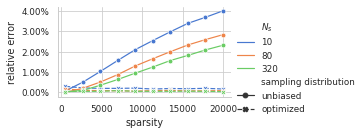

In [377]:
df_sampling['$N_s$'] = df_sampling['num signals']
palette = sns.color_palette('muted', 3)
df_sampling['sampling distribution'] = df_sampling['umbrella'].map(lambda umb: "optimized" if umb else "unbiased")
grid = sns.relplot(x='sparsity', y='relative error', height=5/2.54, hue='$N_s$', style='sampling distribution', aspect=1.8, markers=True, kind='line', ci=None, palette=palette, data=df_sampling)
grid.axes[0, 0].yaxis.set_major_formatter(PercentFormatter(1))
grid.savefig("sampling2.svg", dpi=96)

In [114]:
def mi_estimate(dim, dt):
    t = time_matrix(dim, dt)
    return mutual_information_from_matrix(t, rho, mu, lamda, kappa)

for dim in df['dimensions'].unique():
    for dt in df['dt'].unique():
        df = df.append({'mutual information': mi_estimate(dim, dt), 'dimensions': dim, 'dt': dt, 'estimate': 'Analytical'}, ignore_index=True)
df

,dimensions,marginal entropy,theory,num signals,num responses,umbrella,sparsity,conditional entropy,mutual information,estimate,dt,error,relative error,absolute error,inverse responses,inverse signals
0,1,3.716456,3.630363,300.0,100.0,0.0,2.000000,3.470505,0.245951,Monte Carlo,2.000000,0.086093,0.023715,0.086093,0.01,0.003333
1,1,3.763309,3.630363,300.0,100.0,0.0,5.263158,3.477026,0.286283,Monte Carlo,5.263158,0.132946,0.036621,0.132946,0.01,0.003333
2,1,3.543620,3.630363,300.0,100.0,0.0,8.526316,3.467502,0.076118,Monte Carlo,8.526316,-0.086743,-0.023894,0.086743,0.01,0.003333
3,1,3.464112,3.630363,300.0,100.0,0.0,11.789474,3.478566,-0.014454,Monte Carlo,11.789474,-0.166251,-0.045795,0.166251,0.01,0.003333
4,1,3.529822,3.630363,300.0,100.0,0.0,15.052632,3.472698,0.057124,Monte Carlo,15.052632,-0.100541,-0.027695,0.100541,0.01,0.003333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.155077,Analytical,50.947368,NaN,NaN,NaN,NaN,NaN
1296,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.155077,Analytical,54.210526,NaN,NaN,NaN,NaN,NaN
1297,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.155077,Analytical,57.473684,NaN,NaN,NaN,NaN,NaN
1298,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.155077,Analytical,60.736842,NaN,NaN,NaN,NaN,NaN


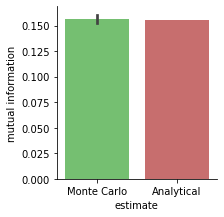

In [134]:
grid = sns.catplot(y='mutual information', x='estimate', kind='bar', height=300/96, palette=palette[2:], data=df)
grid.savefig("1d.svg")

# Umbrella Sampling

In [261]:
args = db.from_sequence(list(itertools.product([10, 150, 250, 400], (1/np.linspace(1/200, 1/100, 10)).astype(int), [1], [8, 32, 64], [True])) * 72, npartitions=72)
dicts = args.starmap(generate_sample)
                        
df_umbr = dicts.to_dataframe()
df_umbr['error'] = df_umbr['marginal entropy'] - df_umbr['theory']
df_umbr['relative error'] = df_umbr['error'] / df_umbr['theory']
df_umbr['inverse responses'] = 1/df_umbr['num responses']
df_umbr['inverse signals'] = 1/df_umbr['num signals']
df_umbr

,dimensions,marginal entropy,theory,num signals,num responses,umbrella,sparsity,dt,error,relative error,inverse responses,inverse signals
npartitions=72,,,,,,,,,,,,
,int64,float64,float64,int64,int64,bool,int64,int64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...


In [262]:
df_umbr = df_umbr.compute()
df_umbr

,dimensions,marginal entropy,theory,num signals,num responses,umbrella,sparsity,dt,error,relative error,inverse responses,inverse signals
0,10,25.572985,25.532583,1,200,True,80,8,0.040401,0.001582,0.005000,1.0
1,10,31.155182,31.121374,1,200,True,320,32,0.033808,0.001086,0.005000,1.0
2,10,33.446145,33.436402,1,200,True,640,64,0.009743,0.000291,0.005000,1.0
3,10,25.244471,25.532583,1,180,True,80,8,-0.288113,-0.011284,0.005556,1.0
4,10,31.459577,31.121374,1,180,True,320,32,0.338203,0.010867,0.005556,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
115,400,1219.976466,1222.390835,1,105,True,12800,32,-2.414369,-0.001975,0.009524,1.0
116,400,1325.686258,1325.024495,1,105,True,25600,64,0.661763,0.000499,0.009524,1.0
117,400,974.508155,974.623158,1,100,True,3200,8,-0.115004,-0.000118,0.010000,1.0
118,400,1221.078625,1222.390835,1,100,True,12800,32,-1.312211,-0.001073,0.010000,1.0


# Reduction of Variance with $N_x$

In [267]:
args = db.from_sequence(list(itertools.product(np.linspace(500, 10000, 5), [200], (1/np.linspace(1/200, 1/100, 10)).astype(int), [400], [False])) * 144, npartitions=36*32)
dicts = args.starmap(generate_sample_with_sparsity).persist()

In [268]:
df_var = dicts.to_dataframe()
df_var = df_var.compute()
df_var

,dimensions,marginal entropy,theory,num signals,num responses,umbrella,sparsity,conditional entropy,mutual information,estimate,dt
0,200,375.817995,375.598405,400,200,False,500.0,374.560042,1.257953,Monte Carlo,2.5
1,200,374.586535,375.598405,400,180,False,500.0,374.558987,0.027548,Monte Carlo,2.5
2,200,376.875741,375.598405,400,163,False,500.0,374.571536,2.304205,Monte Carlo,2.5
3,200,376.147563,375.598405,400,150,False,500.0,374.542976,1.604588,Monte Carlo,2.5
4,200,373.582466,375.598405,400,138,False,500.0,374.521848,-0.939382,Monte Carlo,2.5
...,...,...,...,...,...,...,...,...,...,...,...
6,200,653.441751,645.701711,400,128,False,10000.0,630.439725,23.002026,Monte Carlo,50.0
0,200,652.285762,645.701711,400,120,False,10000.0,630.482256,21.803506,Monte Carlo,50.0
1,200,652.574854,645.701711,400,112,False,10000.0,630.403477,22.171376,Monte Carlo,50.0
2,200,652.484336,645.701711,400,105,False,10000.0,630.426371,22.057965,Monte Carlo,50.0


In [269]:
df_var['error'] = df_var['marginal entropy'] - df_var['theory']
df_var['relative error'] = df_var['error'] / df_var['theory']
df_var['inverse responses'] = 1. / df_var['num responses']

In [275]:
df_var_grouped = df_var.groupby(['sparsity', 'num responses', 'dt']).agg(**{
    'variance': ('marginal entropy', np.var),
    'relative error': ('relative error', np.mean),
    'inverse responses': ('inverse responses', np.mean)
})
df_var_grouped = df_var_grouped.reset_index()
df_var_grouped

,sparsity,num responses,dt,variance,relative error,inverse responses
0,500.0,100,2.500,0.908969,0.000067,0.010000
1,500.0,105,2.500,0.913393,0.000036,0.009524
2,500.0,112,2.500,0.833314,0.000116,0.008929
3,500.0,120,2.500,0.861264,0.000413,0.008333
4,500.0,128,2.500,0.848168,0.000258,0.007812
5,500.0,138,2.500,0.691214,-0.000029,0.007246
6,500.0,150,2.500,0.801522,-0.000063,0.006667
7,500.0,163,2.500,0.559628,0.000063,0.006135
8,500.0,180,2.500,0.507608,-0.000043,0.005556
9,500.0,200,2.500,0.511058,0.000137,0.005000


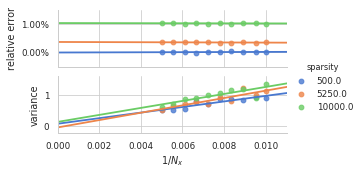

In [343]:
filter_df = df_var_grouped[(df_var_grouped.sparsity == 500) | (df_var_grouped.sparsity == 5250) | (df_var_grouped.sparsity == 10000)]

pg = sns.pairplot(filter_df, hue='sparsity', x_vars=['inverse responses'], y_vars=['relative error', 'variance'], kind='reg',
            plot_kws={'truncate': False, 'ci': None}, aspect=3.5, palette=palette, height=2.8/2.54)
pg.set(xlim=(0.0, 0.011))
pg.axes[0, 0].yaxis.set_major_formatter(PercentFormatter(1))
pg.axes[0, 0].set(ylabel='relative error', ylim=(-0.005, 0.015))
pg.axes[-1, 0].set(xlabel='$1/N_x$', ylabel='variance', ylim=(-0.2, 1.6))
pg.savefig('relative_error_responses.svg', dpi=300)

# Conditional Entropy

In [9]:
df = pd.read_json(path / 'marginal_entropy' / 'data.json')
df = df[df['num signals'] == 1000]

df['sampling'] = np.where(df['umbrella'], 'optimized', 'normal')

df['marginal entropy'] = (df['marginal entropy'] - df['theory']) / df['theory']
df['conditional entropy'] = df['conditional entropy error'] / (df['conditional entropy'] + df['conditional entropy error'])

df = df.melt(id_vars=['dimensions', 'num signals', 'num responses', 'sparsity', 'sampling'], 
             value_vars=['marginal entropy', 'conditional entropy'],
             value_name='relative error')

df.loc[(df.variable == 'marginal entropy') & (df.sampling == 'normal'), 'variable'] = 'marginal entropy\nunbiased sampling'
df.loc[(df.variable == 'marginal entropy') & (df.sampling == 'optimized'), 'variable'] = 'marginal entropy\noptimized sampling'

# cond_unbiased = (df['sampling'] == 'normal') & (df['variable'] == 'marginal entropy')
# cond_optimized = (df['sampling'] == 'optimized') & (df['variable'] == 'marginal entropy')
# df = df.mask(cond_unbiased, df.assign(variable='marginal entropy\nunbiased sampling'))\
#     .mask(cond_optimized, df.assign(variable='marginal entropy\noptimized sampling'))\
#     .groupby(['sparsity', 'variable']).mean().reset_index()

df = df.groupby(['sparsity', 'variable']).agg({'relative error': np.var, 'num responses': np.sum, 'num signals': np.mean}).reset_index()
df['relative error'] = df['relative error'].abs()
df

,sparsity,variable,relative error,num responses,num signals
0,500.000000,conditional entropy,7.831313e-09,51200,1000
1,500.000000,marginal entropy\noptimized sampling,6.157081e-06,25600,1000
2,500.000000,marginal entropy\nunbiased sampling,7.424354e-06,25600,1000
3,3285.714286,conditional entropy,3.010478e-09,51200,1000
4,3285.714286,marginal entropy\noptimized sampling,3.764357e-06,25600,1000
5,3285.714286,marginal entropy\nunbiased sampling,3.165557e-06,25600,1000
6,6071.428571,conditional entropy,2.882173e-09,51200,1000
7,6071.428571,marginal entropy\noptimized sampling,2.875869e-06,25600,1000
8,6071.428571,marginal entropy\nunbiased sampling,3.265464e-06,25600,1000
9,8857.142857,conditional entropy,2.586007e-09,51200,1000


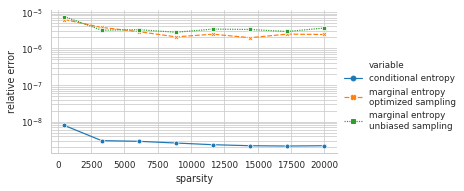

In [10]:
g = sns.relplot(x='sparsity', y='relative error', hue='variable', style='variable', kind='line', markers=True, aspect=2, height=2.7, data=df)
g.set(yscale='log')
g.axes[0, 0].grid(True, which='both')
g.savefig(path / 'marginal_entropy' / 'conditional.svg')

In [296]:
pd.read_json(path / 'marginal_entropy' / 'data.json').groupby(['sparsity', 'num signals', 'umbrella']).sum()

dimensions  marginal entropy         theory  \
sparsity num signals umbrella                                                
500.0    500         False          51200      96134.582324   96153.191656   
                     True           51200      96209.735172   96153.191656   
         538         False          51200      96165.034390   96153.191656   
                     True           51200      96173.910062   96153.191656   
         583         False          51200      96156.018127   96153.191656   
...                                   ...               ...            ...   
20000.0  777         True           51200     176369.363812  176333.940176   
         874         False          51200     179867.444151  176333.940176   
                     True           51200     176343.171110  176333.940176   
         1000        False          51200     179769.597440  176333.940176   
                     True           51200     176361.425663  176333.940176   

                               num responses  conditional entropy  \
sparsity num signals umbrella                                       
500.0    500         False             25600         95883.898452   
                     True              25600         95882.558357   
         538         False             25600         95881.114179   
                     True              25600         95882.585997   
         583         False             25600         95882.740067   
...                                      ...                  ...   
20000.0  777         True              25600        170044.886684   
         874         False             25600        170044.404271   
                     True              25600        170044.890386   
         1000        False             25600        170043.934997   
                     True              25600        170044.180817   

                               conditional entropy error  mutual information  \
sparsity num signals umbrella                                                  
500.0    500         False                      1.546685          250.683872   
                     True                       0.206590          327.176815   
         538         False                     -1.237588          283.920211   
                     True                       0.234230          291.324064   
         583         False                      0.388300          273.278060   
...                                                  ...                 ...   
20000.0  777         True                       0.954654         6324.477128   
         874         False                      0.472240         9823.039881   
                     True                       0.958356         6298.280724   
         1000        False                      0.002967         9725.662443   
                     True                       0.248786         6317.244846   

                                    dt  
sparsity num signals umbrella           
500.0    500         False       640.0  
                     True        640.0  
         538         False       640.0  
                     True        640.0  
         583         False       640.0  
...                                ...  
20000.0  777         True      25600.0  
         874         False     25600.0  
                     True      25600.0  
         1000        False     25600.0  
                     True      25600.0  

[128 rows x 8 columns]